# Visão Computacional - Lista 4

Aqui serão resolvidas as atividades da terceira lista de Visão Computacional pelo aluno Sillas Rocha da Costa, começaremos realizando alguns imports:

In [1]:
from matplotlib import pyplot as plt
import sounddevice as sd
import soundfile as sf
from scipy.io.wavfile import write
import matplotlib.pyplot as plt
import numpy as np

# Exercício 1 - Áudio

Lendo o arquivo de áudio

In [2]:
data60, fs = sf.read("./StarWars60.wav", dtype='float32')
# sd.play(data60, fs)
# status = sd.wait()

Reduzindo para 10 segundos

In [3]:
seconds = 10
data10 = data60[:fs*seconds]
# sd.play(data10, fs)
# status = sd.wait()
write('./StarWars10.wav', fs, data10)

Plotando o resultado

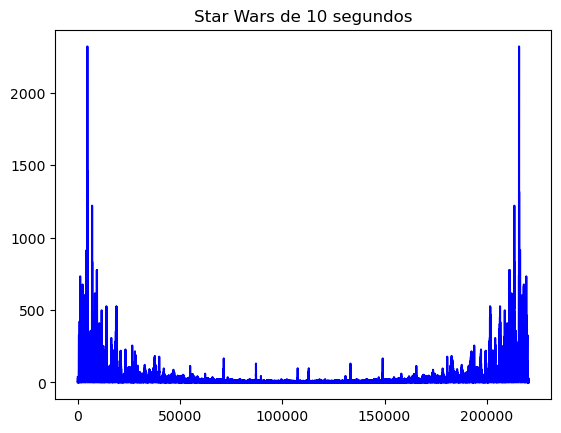

In [7]:
plt.plot(data10)
datahat = np.fft.fft(data10)
plt.plot(abs(datahat), color="blue")
plt.title("Star Wars de 10 segundos")
plt.show()

# Exercício 2 - Compressão com Fourier

In [5]:
p = 0.2
transfomada = np.fft.fft(data10)
freq_range = int(len(transfomada)*p)

transfomada[freq_range:-freq_range] = 0

data_results = np.fft.ifft(transfomada).real

# sd.play(data10, fs)
# status = sd.wait()
# sd.play(data_results, fs)
# status = sd.wait()

O som parece ficar mais abafado e com "menos nitidez" como se houvesse um colchão ou pano cobrindo o microfone na hora da gravação.

# Exercício 3 - Convolução em sinais de áudio com Fourier

a) Filtro com convolução:

In [48]:
def eco_normal(som:np.ndarray, fs:int, atraso:int=0.5) -> np.ndarray:
    range_atraso = int(fs*atraso)
    som_size = len(som)

    s_1 = np.zeros(range_atraso + som_size)
    s_2 = np.zeros(range_atraso + som_size)

    s_1[:som_size] = som
    s_2[range_atraso:] = som

    eco = s_1 + s_2/2

    return eco

def eco_convolve(som:np.ndarray, fs:int, atraso:int=0.5) -> np.ndarray:
    filtro = np.zeros_like(som)
    filtro[0] = 1
    filtro[int(atraso*fs)] = 1/2

    eco = np.fft.ifft(np.fft.fft(som) * np.fft.fft(filtro))

    return eco.real

In [51]:
audio, fs = sf.read("./Coruja.WAV", dtype='float32')  

audio_com_eco = eco_convolve(audio, fs)

sd.play(audio_com_eco, fs)
# status = sd.wait()

b) Reverb:

In [68]:
def reverb_convolve(som:np.ndarray, fs:int, copias:int=10, atraso:float=0.1) -> np.ndarray:
    filtro = np.zeros_like(som)
    filtro[0] = 1

    range_atraso = int(fs*atraso)

    for i in range(1, copias+1):
        index = range_atraso * i

        filtro[index] = (copias-i+1)/(copias+1)


    eco = np.fft.ifft(np.fft.fft(som) * np.fft.fft(filtro))

    # print(filtro[filtro!=0])

    return eco.real

In [69]:
audio, fs = sf.read("./StarWars10.wav", dtype='float32')  

audio_com_eco = reverb_convolve(audio, fs)

sd.play(audio_com_eco, fs)
# status = sd.wait()